# References

I referred to this blog about objection detection with mask-rcnn and applied that to this dataset about cars.
Link: https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

# Importing and Installing libraries

For my code I am using this repository that supports Tensorflow 2+.

In [1]:
!git clone https://github.com/leekunhee/Mask_RCNN.git
!cd Mask_RCNN && python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 149.27 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (572/572), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> buil

In [2]:
import os,sys
import pandas as pd
import numpy as np
from os import listdir
from numpy import zeros, asarray, expand_dims, mean
from matplotlib import pyplot

ROOT_DIR = os.path.abspath("./Mask_RCNN")
sys.path.append(ROOT_DIR) 

from mrcnn.utils import Dataset,extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

import warnings
warnings.filterwarnings("ignore")

# Dataset

First we will read from the csv and try to understand the format of data.

In [4]:
bb_df = pd.read_csv('../input/mask-rcnn-dataset/dataset/bbox_data.csv')

In [5]:
bb_df.head() #displaying the first couple of rows

Name  width  height  xmin  ymin  xmax  ymax
0  10001.jpg    612     408   192   199   230   235
1  10001.jpg    612     408   247   168   291   211
2  10001.jpg    612     408   321   176   366   222
3  10001.jpg    612     408   355   183   387   214
4  10002.jpg    612     408   339   165   378   202

In [6]:
bb_df.describe() #checking the count and overview of data

width       height         xmin         ymin         xmax  \
count  4504.000000  4504.000000  4504.000000  4504.000000  4504.000000   
mean    603.398091   421.916741   266.884769   131.493339   337.009991   
std      40.009302    49.248841   114.093882    61.292438   113.882153   
min     381.000000   272.000000     0.000000     0.000000    21.000000   
25%     612.000000   408.000000   189.000000    89.000000   257.000000   
50%     612.000000   408.000000   269.000000   128.000000   336.000000   
75%     612.000000   408.000000   348.000000   167.250000   416.000000   
max     612.000000   612.000000   590.000000   482.000000   612.000000   

              ymax  
count  4504.000000  
mean    205.056172  
std      65.597120  
min      31.000000  
25%     160.000000  
50%     201.000000  
75%     243.000000  
max     612.000000

In [7]:
bb_df.nunique() #count of unique values in the dataset

Name      1057
width       20
height      96
xmin       548
ymin       326
xmax       542
ymax       353
dtype: int64

As you can see from above that total unique rows for image is less than total number of rows meaning we have some images repeated multiple times i.e some images have multiple cars in them. Which is why some images are repeated to give the data about their multiple bounding boxes.

In [8]:
class FacesDataset(Dataset):
    '''
    Dataset class to load the images and their bounding boxes in the form of masks
    '''
    def load_dataset(self, dataset_dir='../input/mask-rcnn-dataset/dataset/images/', mode='train'):
        '''
        This function is used to load the dataset. We will only use 500 images for training the rest are for validation.
        We also have test set for which we dont have labels but are useful for visually checking 
        for how effective the training was
        '''
        self.add_class('dataset',1,'face')
        if mode == 'train':
            for i in range(3940):
                image_id = bb_df.iloc[i,0]
                img_path = dataset_dir + image_id
                self.add_image('dataset',image_id=image_id, path = img_path)
        if mode == 'val':
            for i in range(3940,4103):
                image_id = bb_df.iloc[i,0]
                img_path = dataset_dir + image_id
                self.add_image('dataset',image_id=image_id, path = img_path)

        if mode == 'test':
            for i in range(4103,len(bb_df)):
                image_id = bb_df.iloc[i,0]
                image_path = dataset_dir + image_id
                self.add_image('dataset',image_id=image_id, path = image_path)
        
    def extract_boxes(self, filename):
        '''
        To get the coordinates of the bounding boxes.
        '''
        boxes = list()
        width = int(bb_df[bb_df['Name']==filename].iloc[0,1])
        height = int(bb_df[bb_df['Name']==filename].iloc[0,2])
        xmin = int(bb_df[bb_df['Name']==filename].iloc[0,3])
        ymin = int(bb_df[bb_df['Name']==filename].iloc[0,4])
        xmax = int(bb_df[bb_df['Name']==filename].iloc[0,5])
        ymax = int(bb_df[bb_df['Name']==filename].iloc[0,6])
        coors = [xmin, ymin, xmax, ymax]
        boxes.append(coors)
        return boxes, width, height
    def load_mask(self, image_id):
        '''
        Takes the co-ordinates and uses that to make it into a mask.
        '''
        info = self.image_info[image_id]
        file = info['id']
        boxes, w, h = self.extract_boxes(file)
        masks = zeros([w, h, len(boxes)], dtype='uint8')
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('face'))
        return masks, asarray(class_ids, dtype='int32')
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [9]:
#Loading all the datasets we will need.
train_set = FacesDataset()
train_set.load_dataset(mode='train')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

val_set = FacesDataset()
val_set.load_dataset(mode='val')
val_set.prepare()
print('Validate: %d' % len(val_set.image_ids))
 
test_set = FacesDataset()
test_set.load_dataset(mode='test')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 3940
Validate: 163
Test: 401


Here we will visualise some of the images from the dataset along side their masks.

In [10]:
def plot(num_img=5):
    for i in range(num_img):
        image_id = np.random.randint(0,len(train_set.image_ids))
        image = train_set.load_image(image_id)
        mask, class_ids = train_set.load_mask(image_id)
        pyplot.imshow(image)
        pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.3)
        pyplot.show()

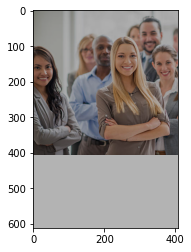

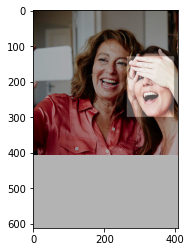

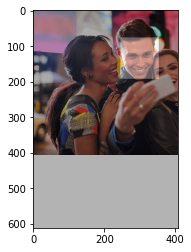

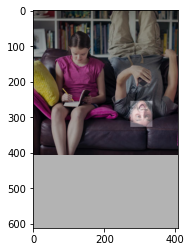

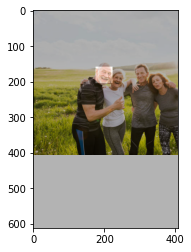

In [11]:
plot()

# Training

This config file contains a lot of important parameters for model training.

In [12]:
class FacesConfig(Config):
    NAME = "faces_cfg"
    NUM_CLASSES = 2 #Bckground is counted as class too so background + cars = 2 labels
    STEPS_PER_EPOCH = 200
    VALIDATION_STEPS = 20
    IMAGES_PER_GPU = 1
    
config = FacesConfig()

In [13]:
config.display() #list of all available configurations


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [14]:
model = MaskRCNN(mode='training', model_dir='./', config=config)

We are going to load pre-trained weights for this task. This will save us a lot of time because these algorithms can take a lot of time to converge

In [15]:
model.load_weights('../input/mask-rcnn-coco-weights/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [16]:
model.train(train_set, val_set, learning_rate=config.LEARNING_RATE, epochs=10, layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./faces_cfg20221202T0210/mask_rcnn_faces_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (Batch

# Evaluation

We need to define a seperate config file for predictions purposes.

In [18]:
class PredictionConfig(Config):
    NAME = "faces_cfg"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

In [19]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

Loading the saved weights to perform inference.

In [52]:
for i in listdir():
    if i[:4]=='face':
        path=i
model.load_weights('./'+path+'/mask_rcnn_faces_cfg_0010.h5', by_name=True)

Re-starting from epoch 10


Here we will calculate mean average precision for our model. To know in detail what it means try referring to this blog
https://towardsdatascience.com/map-mean-average-precision-might-confuse-you-5956f1bfa9e2

In [53]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    mAP = mean(APs)
    return mAP

In [ ]:
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
val_mAP = evaluate_model(val_set, model, cfg)
print("Validation mAP: %.3f" % val_mAP)

# Actual vs Predicted

Fianlly we will compare our model preformances by simply seeing how well it is detecting cars compared to the real bounding boxes.

In [55]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    for i in range(n_images):
        count = 0
        id = np.random.randint(0,len(dataset.image_ids))
        pyplot.figure(figsize=(50, 50))
        image = dataset.load_image(id)
        mask, _ = dataset.load_mask(id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)[0]
        pyplot.subplot(n_images, 2, i*2+1)
        pyplot.imshow(image)
        pyplot.title('Actual')
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        pyplot.subplot(n_images, 2, i*2+2)
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        for box in yhat['rois']:
            count +=1
            y1, x1, y2, x2 = box
            width, height = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            ax.add_patch(rect)
        print('number of people in the {} picture is'.format(i),count)
    pyplot.show()

number of people in the 0 picture is 5
number of people in the 1 picture is 4
number of people in the 2 picture is 4
number of people in the 3 picture is 3
number of people in the 4 picture is 4


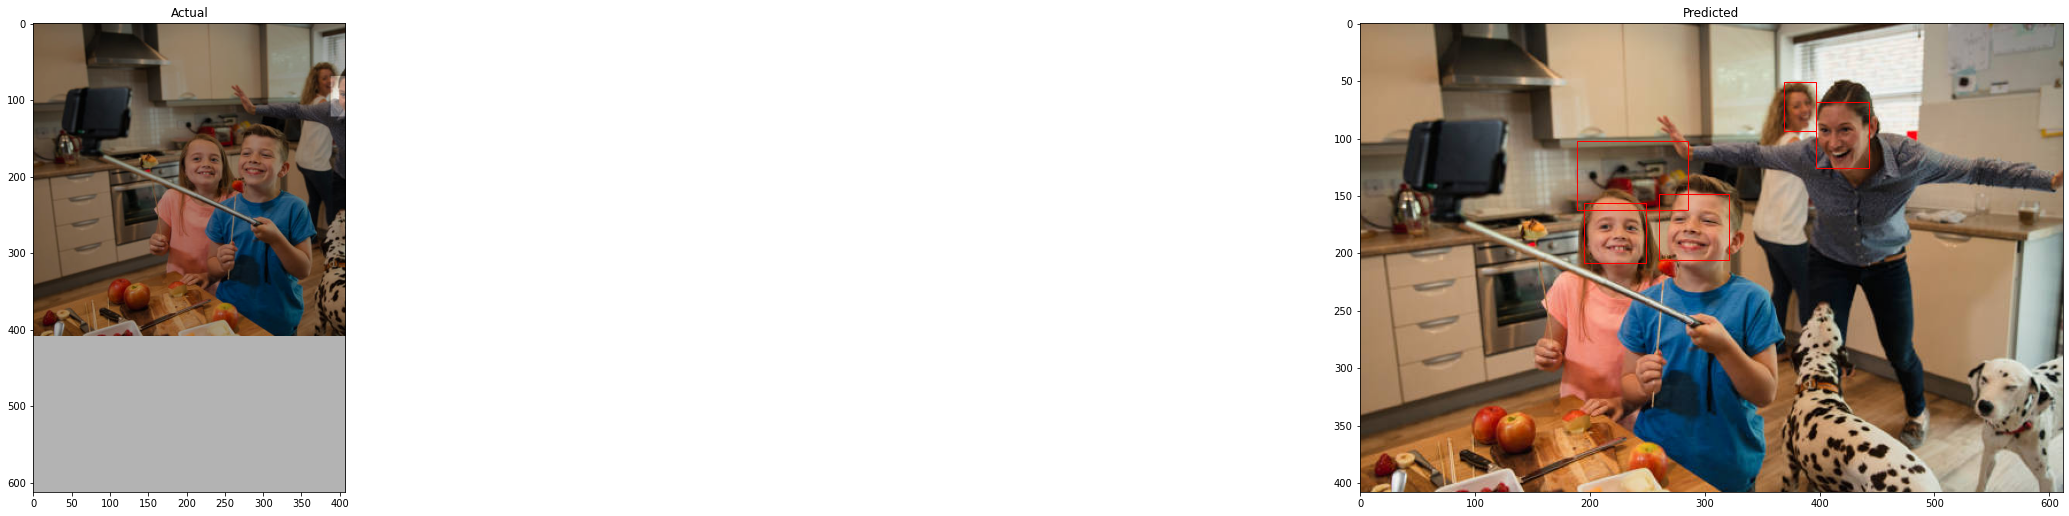

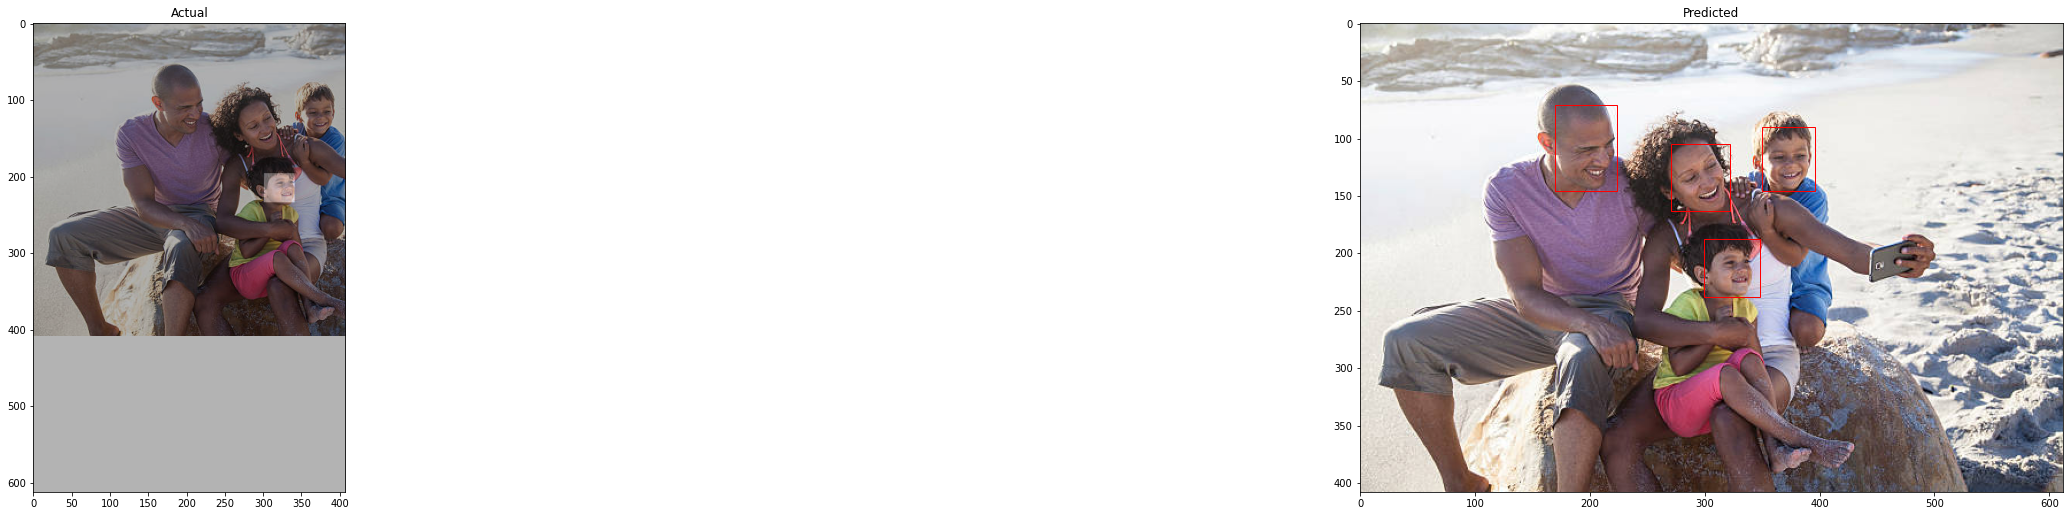

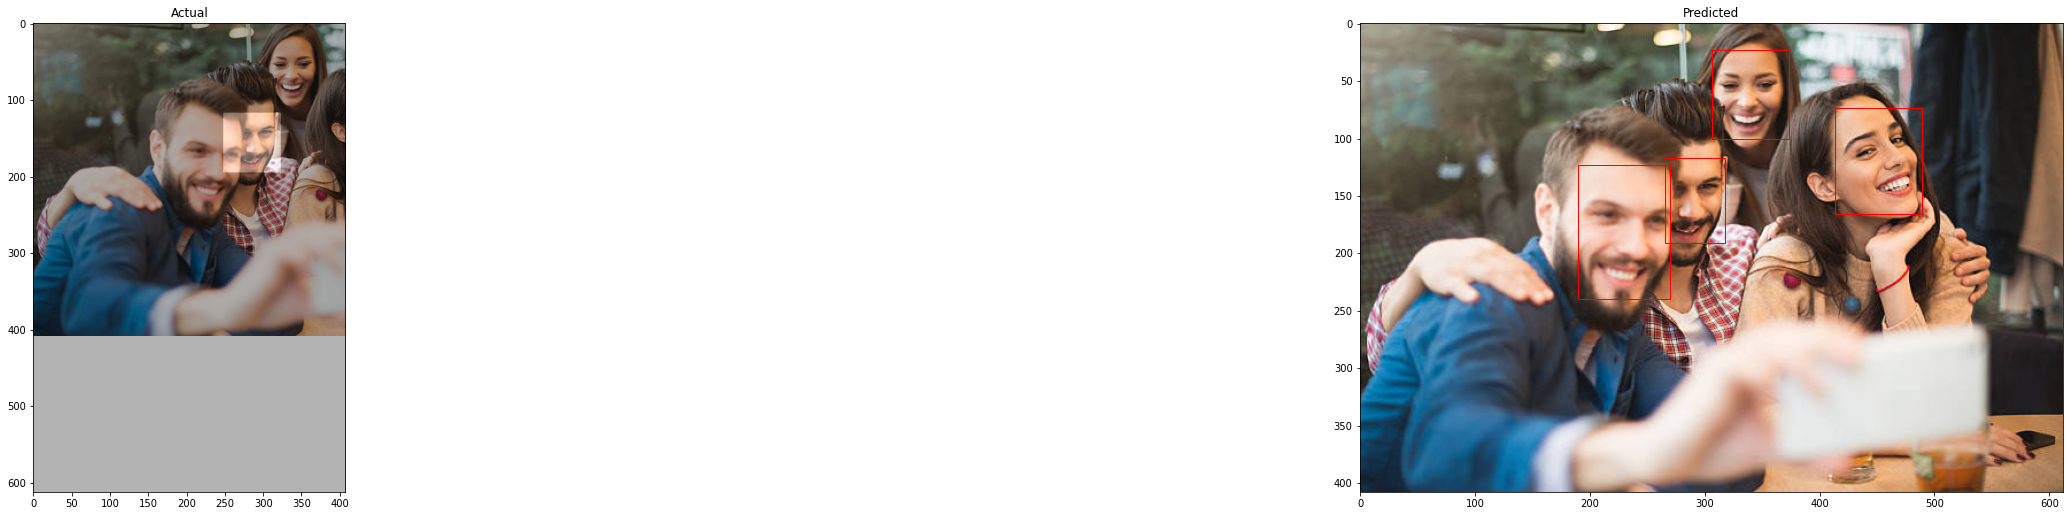

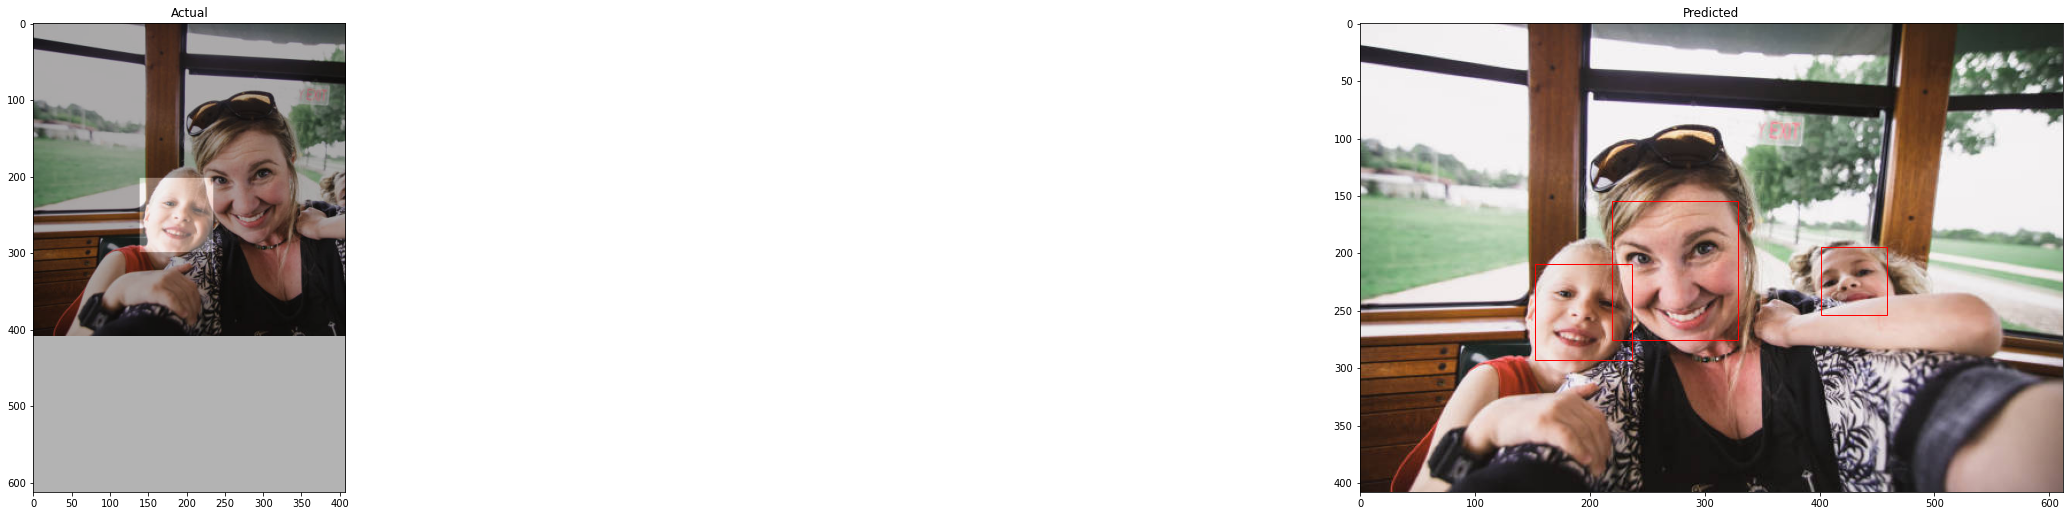

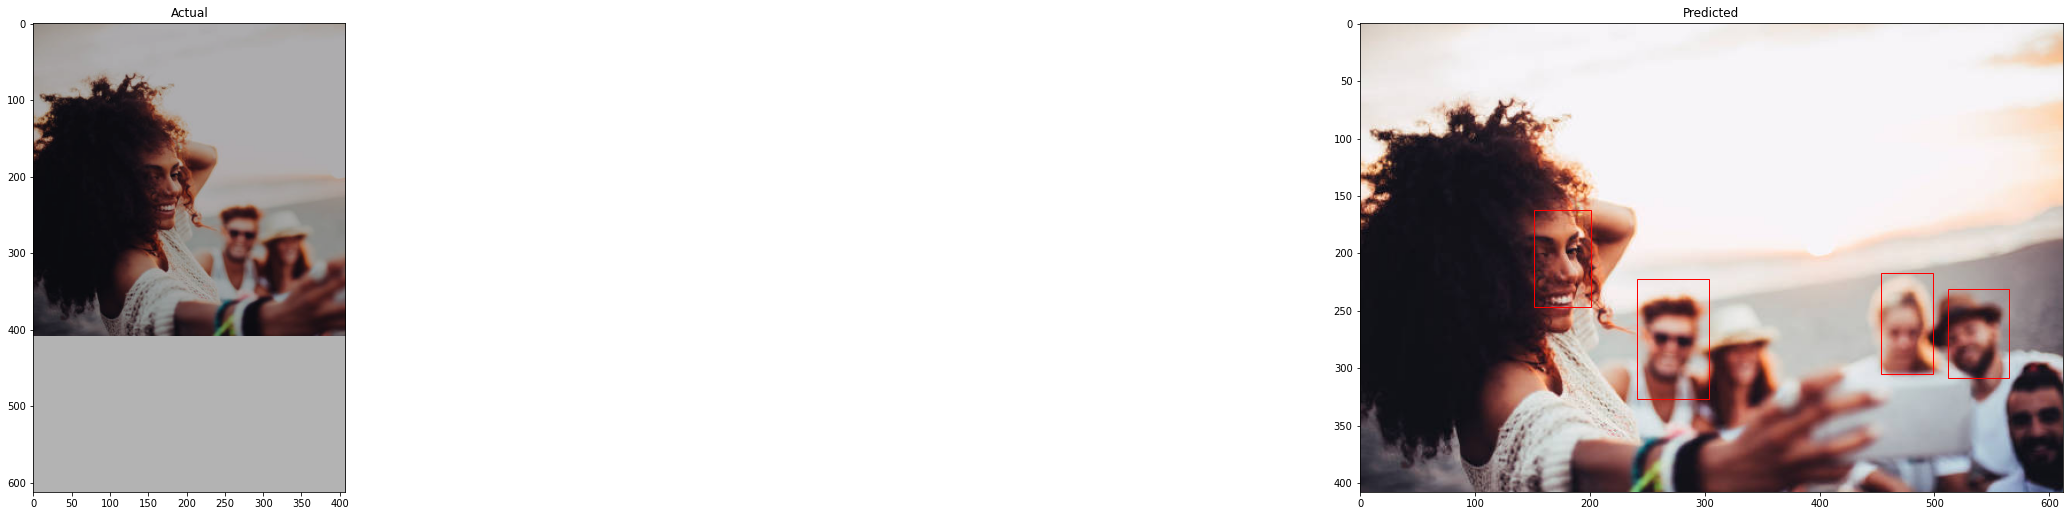

In [56]:
from matplotlib.patches import Rectangle
plot_actual_vs_predicted(test_set, model, cfg)

Thank you for your time, and dont forget to upvote this notebook if you found it helpful.